# YOLO v2
## 基于 Tensorflow2.4 的实现
## 使用 VOC2007 和 VOC2012 数据集

In [1]:
!mkdir logs
!mkdir weight

In [2]:
# 导包
import os
import struct
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from lxml import etree

In [3]:
# 导包并测试
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *

print(tf.__version__)
tf.test.gpu_device_name()

2.3.1


'/device:GPU:0'

#### 1、配置参数

In [4]:
class Config:
    """
    参考https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-voc.cfg
    """
    def __init__(self):
        # Training
        self.IMAGE_W = 416
        self.IMAGE_H = 416
        self.GRID_W = 13
        self.GRID_H = 13
        self.ANCHORS_NUM = 5
        self.CLASSES_NUM = 20
        self.NOOBJECT_LAMBDA = 1
        self.OBJECT_LAMBDA = 5
        self.CLASS_LAMBDA = 1
        self.COORD_LAMBDA = 1
        # 论文中提到的K-means算法得到的VOC数据集的5个box的信息
        self.ANCHORS = [1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071]
        self.ANCHORS = np.array(self.ANCHORS)
        self.ANCHORS = self.ANCHORS.reshape(-1, 2)

        self.VOC_NAME_LABEL_CLASS = {
            'none': (0, 'Background'),
            'aeroplane': (1, 'Vehicle'),
            'bicycle': (2, 'Vehicle'),
            'bird': (3, 'Animal'),
            'boat': (4, 'Vehicle'),
            'bottle': (5, 'Indoor'),
            'bus': (6, 'Vehicle'),
            'car': (7, 'Vehicle'),
            'cat': (8, 'Animal'),
            'chair': (9, 'Indoor'),
            'cow': (10, 'Animal'),
            'diningtable': (11, 'Indoor'),
            'dog': (12, 'Animal'),
            'horse': (13, 'Animal'),
            'motorbike': (14, 'Vehicle'),
            'person': (15, 'Person'),
            'pottedplant': (16, 'Indoor'),
            'sheep': (17, 'Animal'),
            'sofa': (18, 'Indoor'),
            'train': (19, 'Vehicle'),
            'tvmonitor': (20, 'Indoor'),
        }
        self.VOC_NAME_LABEL = {key:v[0] for key,v in self.VOC_NAME_LABEL_CLASS.items()}
        self.VOC_LABEL_NAME = {v[0]:key for key,v in self.VOC_NAME_LABEL_CLASS.items()}

#### 2、处理和构造数据集

In [5]:
def read_example_list(path):
    """
    读取训练集或验证集
    :param path: 路径
    :return: list
    """
    with tf.io.gfile.GFile(path) as f:
        lines = f.readlines()
    return [line.strip().split(' ')[0] for line in lines]

def parse_xml_to_dict(xml):
    """
    递归地将 xml 转化为 字典
    :param xml: 通过解析 xml 得到的 lxml.etree 格式
    :return: 包含 xml 的字典
    """
    if len(xml) == 0:
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml_to_dict(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

def transform(x, y, config):
    """
    从数据集中生成一个 batch size 的标签值， 准备在计算损失时和预测值比较
    :param x: 一个 batch size 的图片 (batch size, h, w, 3)
    :param y: 一个batch size 的 label (batch size, xmin, ymin, xmax, ymax, label)
    :param config: 配置
    :return: batch
        - x : 要预测的图片（batch_size, IMAGE_H, IMAGE_W, 3）
        - detector_mask : 是否有 bounding box 在格子内预测（batch, size, GRID_W, GRID_H, anchors_num, 1）
        - y_true_anchor_boxes : bounding box 坐标（batch_size, GRID_W, GRID_H, anchors_num, 5）
        - y_true_class_hot : 预测类别的 one hot 编码（batch_size, GRID_W, GRID_H, anchors_num, class_num)
        - y_true_boxes_all : 标签值（batch_size, max annotation(这里设置为100), 5）
    """
    anchors = config.ANCHORS
    anchors_num = anchors.shape[0]
    y = y.numpy()
    batch_size = y.shape[0]
    detector_mask = np.zeros([batch_size, config.GRID_W, config.GRID_H, anchors_num, 1])
    y_true_anchor_boxes = np.zeros([batch_size, config.GRID_W, config.GRID_H, anchors_num, 5])
    y_true_class_hot = np.zeros([batch_size, config.GRID_W, config.GRID_H, anchors_num, config.CLASSES_NUM])
    y_true_boxes_all = np.zeros(y.shape)

    for i in range(batch_size):
        boxes = y[i]
        for j, box in enumerate(boxes):
            w = box[2] - box[0]
            h = box[3] - box[1]
            cx = (box[0] + box[2])/2  # 中心点坐标
            cy = (box[1] + box[3])/2

            w *= config.GRID_W
            h *= config.GRID_H
            cx *= config.GRID_W
            cy *= config.GRID_H

            y_true_boxes_all[i, j] = np.array([cx, cy, w, h, box[4]])
            if w * h <= 0:
                continue
            # 网格 index
            cell_col = np.floor(cx).astype(np.int)
            cell_row = np.floor(cy).astype(np.int)
            # 寻找 IoU 最高的 anchor
            anchors_w, anchors_h = anchors[:, 0], anchors[:, 1]
            intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
            union = anchors_w * anchors_h + w * h - intersect
            iou = intersect / union
            anchor_best = np.argmax(iou)

            class_index = int(box[4])
            y_true_anchor_boxes[i, cell_col, cell_row, anchor_best] = [cx, cy, w, h, class_index]
            y_true_class_hot[i, cell_col, cell_row, anchor_best, class_index-1] = 1
            detector_mask[i, cell_col, cell_row, anchor_best] = 1

    detector_mask = tf.convert_to_tensor(detector_mask, dtype='int64')
    y_true_anchor_boxes = tf.convert_to_tensor(y_true_anchor_boxes, dtype='float32')
    y_true_boxes_all = tf.convert_to_tensor(y_true_boxes_all, dtype='float32')
    y_true_class_hot = tf.convert_to_tensor(y_true_class_hot, dtype='float32')
    batch = (x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all)
    return batch

In [6]:
# 法一：先生成tfrecords，读取时再一个个的batch解析
IMAGE_FEATURE_MAP = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32), # 如果数据中存放的list长度大于1, 表示数据是不定长的, 使用VarLenFeature解析
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    'image/object/view': tf.io.VarLenFeature(tf.string),
}

def parse_example(serialized_example, height, width):
    x = tf.io.parse_single_example(serialized_example, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (height,width))
    labels = tf.cast(tf.sparse.to_dense(x['image/object/class/label']), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']), # shape: [m]
                        tf.sparse.to_dense(x['image/object/bbox/ymin']), # shape: [m]
                        tf.sparse.to_dense(x['image/object/bbox/xmax']), # shape: [m]
                        tf.sparse.to_dense(x['image/object/bbox/ymax']), # shape: [m]
                        labels  # shape: [m]
                        ], axis=1) # shape:[m, 5], m是图片中目标的个数, 每张图片的m可能不一样
    # 每个图片最多包含100个目标
    paddings = [[0, 100 - tf.shape(y_train)[0]], [0, 0]] # 上下左右分别填充0, 100 - tf.shape(y_train)[0], 0, 0
    y_train = tf.pad(y_train, paddings)
    return x_train, y_train

def OB_tfrecord_dataset(dataset_path, batch_size, config, shuffle=False):
    files = tf.data.Dataset.list_files(dataset_path)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(lambda x:parse_example(x, height=config.IMAGE_H, width=config.IMAGE_W))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # 提前获取数据存在缓存里来减少gpu因为缺少数据而等待的情况
    return dataset

In [7]:
# 法二：即时的从硬盘读取，不用生成tfrecords，不需事先把每张图片的标签读进来
def get_imgPath_and_annotations(data_path, years, config,
                                image_subdirectory = 'JPEGImages',
                                annotations_dir = 'Annotations',
                                ignore_difficult_instances = False):
    """
    得到图片的路径和box
    :param data_path: 根目录
    :param years: 数据集年份 2007/2012
    :param config: 配置
    :param image_subdirectory: 图片子文件夹
    :param annotations_dir: 标签子文件夹
    :param ignore_difficult_instances: 忽略复杂数据
    :return: 路径 box
    """
    annotations_list = []
    for year in years.keys():
        sets = years[year]
        for _set in sets:
            examples_path = os.path.join(data_path, year, 'ImageSets', 'Main', _set + '.txt')
            annotations_path = os.path.join(data_path, year, annotations_dir)
            examples_list = read_example_list(examples_path)
            annotation_list = [os.path.join(annotations_path, example + '.xml') for example in examples_list]
            annotations_list += annotation_list

    img_names = []
    max_obj = 200
    annotations = []  # 存放每个图片的box
    for path in annotations_list:
        with tf.io.gfile.GFile(path, 'r') as f:
            xml_str = f.read()
        xml = etree.fromstring(xml_str)
        data = parse_xml_to_dict(xml)['annotation']
        width = int(data['size']['width'])
        height = int(data['size']['height'])

        boxes = []
        if 'object' not in data:
            continue
        for obj in data['object']:
            difficult = bool(int(obj['difficult']))
            if ignore_difficult_instances and difficult:
                continue
            box = np.array([
                float(obj['bndbox']['xmin']) / width,
                float(obj['bndbox']['ymin']) / height,
                float(obj['bndbox']['xmax']) / width,
                float(obj['bndbox']['ymax']) / height,
                config.VOC_NAME_LABEL[obj['name']]
            ])
            boxes.append(box)  # 一个图片的box可能有多个
        boxes = np.stack(boxes)
        annotations.append(boxes)

        img_path = os.path.join(data['folder'], image_subdirectory, data['filename'])
        img_path = os.path.join(data_dir, img_path)
        img_names.append(img_path)
    true_boxes = np.zeros([len(img_names), max_obj, 5])
    for idx, boxes in enumerate(annotations):
        true_boxes[idx, :boxes.shape[0]] = boxes
    return img_names, true_boxes

def parse_image(filename, true_boxes, img_h, img_w):
    """
    得到图片和 box
    :param filename: 图片路径
    :param true_boxes: box
    :param img_h: 期望图片长
    :param img_w: 期望图片宽
    :return: 图片 box
    """
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (img_h, img_w))
    return image, true_boxes

def OB_tensor_slices_dataset(data_path, years, batch_size, config, shuffle=False):
    img_names, boxes = get_imgPath_and_annotations(data_path, years, config)
    dataset = tf.data.Dataset.from_tensor_slices((img_names, boxes))
    dataset = dataset.map(lambda x, y:parse_image(x, y, img_h=config.IMAGE_H, img_w=config.IMAGE_W))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # 提前获取数据存在缓存里来减少gpu因为缺少数据而等待的情况
    return dataset

#### 3、定义 YOLO 模型

In [8]:
def space_to_depth(x):
    return tf.nn.space_to_depth(x, block_size=2)

def yolo(config):
    """
    训练模型，即去掉最后一个卷积层，转而增加了三个3*3*1024的卷积层,集体参看yolov2-voc.cfg文件
    :param config: 配置文件
    :return: 网络模型
    """
    input_image = tf.keras.layers.Input((config.IMAGE_H, config.IMAGE_W, 3), dtype='float32')
    # 1
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # 3
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 4
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 5
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 19 把最后一层卷积层移除,添加3个1024*3*3卷积层
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 21 passthrough层
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth)(skip_connection)
    x = concatenate([skip_connection, x])
    # 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    # 23 1*1的卷积层生成预测输出
    x = Conv2D(config.ANCHORS_NUM * (4 + 1 + config.CLASSES_NUM), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((config.GRID_W, config.GRID_H, config.ANCHORS_NUM, 4 + 1 + config.CLASSES_NUM))(x)

    yolo_model = keras.models.Model(input_image, output)
    return yolo_model

#### 4、加载预训练权重

In [9]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, = struct.unpack('i', w_f.read(4))
            minor, = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10+minor) >=2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, yolo_model, conv_num=23, if_last=False):
        conv_num_read = conv_num
        if not if_last:
            conv_num_read = conv_num - 1

        for i in range(1, conv_num + 1):
            try:
                conv_layer = yolo_model.get_layer('conv_' + str(i))
                if i < conv_num:
                    norm_layer = yolo_model.get_layer('norm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta = self.read_bytes(size)  # bias
                    gamma = self.read_bytes(size)  # scale
                    mean = self.read_bytes(size)  # mean
                    var = self.read_bytes(size)  # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

        if not if_last:
          layer = yolo_model.layers[-2] # last convolutional layer
          layer.trainable = True
          weights = layer.get_weights()
          new_kernel = np.random.normal(size=weights[0].shape)/(13*13)
          new_bias = np.random.normal(size=weights[1].shape)/(13*13)
          layer.set_weights([new_kernel, new_bias])

    def reset(self):
        self.offset = 0

#### 5、IoU 和 损失函数

In [10]:
def cal_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    """
    计算 box1 和 box2 的 IoU
    """
    xmin1 = x1 - 0.5 * w1
    xmax1 = x1 + 0.5 * w1
    ymin1 = y1 - 0.5 * h1
    ymax1 = y1 + 0.5 * h1
    xmin2 = x2 - 0.5 * w2
    xmax2 = x2 + 0.5 * w2
    ymin2 = y2 - 0.5 * h2
    ymax2 = y2 + 0.5 * h2
    inter_x = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    inter_y = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    inter = inter_x * inter_y
    union = w1 * h1 + w2 * h2 - inter
    iou = inter / (union + 1e-6)
    return iou

def yolo_loss(detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all, y_pred, config):
    """
    损失函数
    :param detector_mask: shape(batch_size, GRID_W, GRID_H, anchors_count, 1)
    :param y_true_anchor_boxes: shape(batch_size, GRID_W, GRID_H, anchors_count, 5)
    :param y_true_class_hot: one hot编码 shape(batch_size, GRID_W, GRID_H, anchors_count, class_count)
    :param y_true_boxes_all: (x, y, w, h, c)
    :param y_pred: shape(batch_size, GRID_W, GRID_H, anchors_count, 5 + labels count)
    :param config: 配置
    :return: loss
    """
    # 0-GRID_W -1 / GRID_H -1
    cell_coord_x = tf.cast(tf.reshape(tf.tile(tf.range(config.GRID_W), [config.GRID_H]), (1, config.GRID_H, config.GRID_W, 1, 1)), tf.float32)
    cell_coord_y = tf.transpose(cell_coord_x, (0,2,1,3,4))
    cell_coords = tf.tile(tf.concat([cell_coord_x, cell_coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])

    # 0-GRID_W / GRID_H
    anchors = config.ANCHORS

    # 0-GRID_W / GRID_H
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = pred_xy + cell_coords
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors

    # 1、坐标损失（coordinate loss）
    # 根据gt的wh计算系数，系数作用是w和h值越小，损失系数越大，可以更好地学习尺度较小的box
    lambda_wh = K.expand_dims(2-(y_true_anchor_boxes[:,:,:,:,2]/config.GRID_W) * (y_true_anchor_boxes[:,:,:,:,3]/config.GRID_H))
    detector_mask = K.cast(detector_mask, tf.float32)  # batch_size, GRID_W, GRID_H, n_anchors, 1
    n_objs = K.sum(K.cast(detector_mask>0, tf.float32))
    # 基于预测值计算坐标损失
    y_txy = y_true_anchor_boxes[...,0:2] - cell_coords
    y_twh = K.log(y_true_anchor_boxes[...,2:4]*1.0/anchors + 1e-16)
    pred_txy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_twh = y_pred[:,:,:,:,2:4]
    loss_xy = config.COORD_LAMBDA * K.sum(detector_mask * K.square(y_txy - pred_txy)) / (n_objs + 1e-6)
    loss_wh = config.COORD_LAMBDA * K.sum(lambda_wh * detector_mask * K.square(y_twh - pred_twh)) / (n_objs + 1e-6)
    loss_coord = loss_xy + loss_wh

    # 2、类别损失
    pred_class = K.softmax(y_pred[:,:,:,:,5:])
    loss_cls = detector_mask * K.square(y_true_class_hot - pred_class)
    loss_cls = config.CLASS_LAMBDA * K.sum(loss_cls) / (n_objs + 1e-6)

    # 3、bounding box置信度损失
    # 3.1、包含目标的预测的bounding box置信度损失
    # 预测值和标记值的 IoU
    x1 = y_true_anchor_boxes[...,0]
    y1 = y_true_anchor_boxes[...,1]
    w1 = y_true_anchor_boxes[...,2]
    h1 = y_true_anchor_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    iou = cal_iou(x1, y1, w1, h1, x2, y2, w2, h2)
    iou = K.expand_dims(iou, -1)
    # 使用 IoU 计算置信度的 target
    pred_conf = K.sigmoid(y_pred[...,4:5])
    loss_conf_obj = config.OBJECT_LAMBDA * K.sum(detector_mask * K.square(iou - pred_conf)) / (n_objs + 1e-6)
    # 3.2、不包含目标的预测的bounding box置信度损失
    # 预测值bounding box的xmin, ymin, xmax, ymax
    pred_xy = K.expand_dims(pred_xy, 4)  # shape(batch_size, GRID_W, GRID_H, n_anchors, 1, 2)
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_min = pred_xy - pred_wh_half
    pred_max = pred_xy + pred_wh_half
    # 标记值bounding box的xmin, ymin, xmax, ymax
    true_boxes_shape = K.int_shape(y_true_boxes_all)
    true_boxes_grid = K.reshape(y_true_boxes_all, [true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]])
    true_xy = true_boxes_grid[...,0:2]  # shape(batch_size, 1, 1, 1, max_annotation, 2)
    true_wh = true_boxes_grid[...,2:4]  # shape(batch_size, 1, 1, 1, max_annotation, 2)
    true_wh_half = true_wh * 0.5
    true_min = true_xy - true_wh_half
    true_max = true_xy + true_wh_half
    # 计算每一个预测的box与所有标记的box的IoU，找出最大的IOU，如果小于阈值(0.6,并且不负责GT，根据1 - detector_mask)，该预测的box就加入noobj，计算置信度损失
    intersect_min = K.maximum(pred_min, true_min)  # shape(batch_size, GRID_W, GRID_H, n_anchors, max_annotation, 2)
    intersect_max = K.minimum(pred_max, true_max)  # shape(batch_size, GRID_W, GRID_H, n_anchors, max_annotation, 2)
    intersect_wh = K.maximum(intersect_max - intersect_min, 0.)  # shape(batch_size, GRID_W, GRID_H, n_anchors, max_annotation, 1)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]  # shape(batch_size, GRID_W, GRID_H, n_anchors, max_annotation, 1)
    pred_area = pred_wh[..., 0] * pred_wh[..., 1]  # shape(batch_size, GRID_W, GRID_H, n_anchors, 1, 1)
    true_area = true_wh[..., 0] * true_wh[..., 1]  # shape(batch_size, GRID_W, GRID_H, n_anchors, max_annotation, 1)
    union_area = pred_area + true_area - intersect_area
    iou_score = intersect_area / union_area  # shape(batch_size, GRID_W, GRID_H, n_anchors, max_annotation, 1)
    best_iou = K.max(iou_score, axis=4)  # Best IOU scores.
    best_iou = K.expand_dims(best_iou)  # shape(batch_size, GRID_W, GRID_H, n_anchors, 1)
    # 计算无目标损失
    no_object_detection = K.cast(best_iou < 0.6, K.dtype(best_iou))
    noobj_mask = no_object_detection * (1 - detector_mask)
    n_noobj  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    loss_conf_noobj =  config.NOOBJECT_LAMBDA * K.sum(noobj_mask * K.square(-pred_conf)) / (n_noobj + 1e-6)
    # 4、三种损失汇总
    loss_conf = loss_conf_noobj + loss_conf_obj
    loss = loss_conf + loss_cls + loss_coord
    sub_loss = [loss_conf, loss_cls, loss_coord]
    return loss, sub_loss

def save_best_weights(model, name, val_loss_avg):
    """
    保存最好的权重
    """
    name = name + '_' + str(val_loss_avg) + '.h5'
    path_name = os.path.join('weight/', name)
    model.save_weights(path_name)
    return path_name

def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

#### 6、开始训练

In [11]:
# 准备数据
data_dir = '../input/voc-2007-2012/VOCdevkit'
val_set = {'VOC2012':['val']}
train_set = {'VOC2007':['train', 'val', 'test'], 'VOC2012':['train']}

batch_size = 6
num_epochs = 200
num_iterations = 30
train_name = 'training_1'
cfg = Config()
model_weight_path = '../input/voc-2007-2012/weight/yolo.weights'
n_progress = 20  # 进度条份数

# log（tensorboard）
summery_writer = tf.summary.create_file_writer(os.path.join('logs/', train_name), flush_millis=20000)
summery_writer.set_as_default()

dataset_train = OB_tensor_slices_dataset(data_dir, train_set, batch_size, cfg, shuffle=True)
dataset_val = OB_tensor_slices_dataset(data_dir, val_set, batch_size, cfg, shuffle=False)
len_batches_train = tf.data.experimental.cardinality(dataset_train).numpy()
len_batches_val = tf.data.experimental.cardinality(dataset_val).numpy()

In [12]:
# 准备模型
weight_reader = WeightReader(model_weight_path)
model = yolo(cfg)
weight_reader.load_weights(model)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

In [13]:
# 准备训练
train_loss_history = []
val_loss_history = []
best_val_loss = 1e6
initial_learning_rate = 2e-5
decay_epochs = 30 * num_iterations
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_epochs,
    decay_rate=0.5,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
train_layers = ['conv_22', 'norm_22', 'conv_23']
train_vars = []
for name in train_layers:
     train_vars += model.get_layer(name).trainable_variables

In [14]:
# 开始训练
for epoch in range(num_epochs):
    epoch_loss = []
    epoch_sub_loss = []
    epoch_val_loss = []
    epoch_val_sub_loss = []
    print('\nEpoch {} :'.format(epoch))

    # train
    for bs_idx, (x, y) in enumerate(dataset_train):
        x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all = transform(x, y, cfg)
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            loss, sub_loss = yolo_loss(detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all, y_pred, cfg)
            _loss = loss * 0.01
        grads = tape.gradient(_loss, train_vars)
        optimizer.apply_gradients(grads_and_vars=zip(grads, train_vars))
        epoch_loss.append(loss)
        epoch_sub_loss.append(sub_loss)
        if (bs_idx + 1) % (math.ceil(num_iterations / n_progress)) == 0:
            print('-', end='')
        if (bs_idx + 1) == num_iterations:
            break

    # val
    for bs_idx, (x,y) in enumerate(dataset_val):
        x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all = transform(x, y, cfg)
        with tf.GradientTape() as tape:
            y_pred = model(x, training=False)
            loss, sub_loss = yolo_loss(detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all, y_pred, cfg)
        epoch_val_loss.append(loss)
        epoch_val_sub_loss.append(sub_loss)
        print('-', end='')
        if (bs_idx+1)==1:
            break

    # 记录
    loss_avg = np.mean(np.array(epoch_loss))
    sub_loss_avg = np.mean(np.array(epoch_sub_loss), axis=0)
    val_loss_avg = np.mean(np.array(epoch_val_loss))
    val_sub_loss_avg = np.mean(np.array(epoch_val_sub_loss), axis=0)

    log_loss(loss_avg, val_loss_avg, step=epoch)
    train_loss_history.append(loss_avg)
    val_loss_history.append(val_loss_avg)

    if loss_avg < best_val_loss:
        print('\nfind better model for train')
        best_model_path = save_best_weights(model, train_name+'_epoch%d' % epoch, loss_avg)
        best_val_loss = loss_avg
    print(' \ntrain_loss={:.3f} (conf={:.3f}, class={:.3f}, coords={:.3f}), val_loss={:.3f} (conf={:.3f}, class={:.3f}, coords={:.3f})'.format(
            loss_avg, sub_loss_avg[0], sub_loss_avg[1], sub_loss_avg[2], val_loss_avg, val_sub_loss_avg[0], val_sub_loss_avg[1], val_sub_loss_avg[2]))
save_best_weights(model, train_name+'_epoch_final', 666)


Epoch 0 :
----------------
find better model for train
 
train_loss=172.895 (conf=142.315, class=0.954, coords=29.626), val_loss=29.923 (conf=3.964, class=0.949, coords=25.010)

Epoch 1 :
---------------- 
train_loss=76252.180 (conf=76223.266, class=0.950, coords=27.955), val_loss=29.882 (conf=3.903, class=0.948, coords=25.031)

Epoch 2 :
---------------- 
train_loss=1062.631 (conf=1033.927, class=0.948, coords=27.756), val_loss=29.820 (conf=3.818, class=0.947, coords=25.055)

Epoch 3 :
----------------
find better model for train
 
train_loss=65.492 (conf=36.872, class=0.957, coords=27.663), val_loss=29.825 (conf=3.778, class=0.947, coords=25.100)

Epoch 4 :
---------------- 
train_loss=329.256 (conf=298.381, class=0.945, coords=29.929), val_loss=29.790 (conf=3.712, class=0.947, coords=25.132)

Epoch 5 :
---------------- 
train_loss=140.513 (conf=110.448, class=0.946, coords=29.118), val_loss=29.769 (conf=3.672, class=0.946, coords=25.151)

Epoch 6 :
----------------
find better mode

'weight/training_1_epoch_final_666.h5'

#### 开始测试

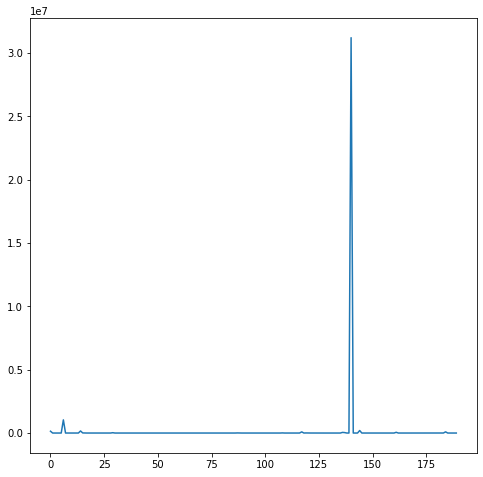

In [15]:
def plot_img(img, boxes, labels, scores, config):
    """
    画图
    :param img: 图片
    :param boxes: 物体位置box
    :param labels: 标签
    :param scores: 得分
    :param config: 配置
    :return:
    """
    # 画图
    fig, ax = plt.subplots(1, figsize=(8, 8))
    img = img.numpy()
    boxes = boxes.numpy().reshape(-1, 4)
    labels = labels.numpy()
    scores = scores.numpy()

    ax.show(img)
    img_h, img_w = img.shape[0: 2]
    colors = ['r', 'orange', 'g', 'b', 'pink', 'purple']
    count = 0
    for box, label, score in zip(boxes, labels, scores):
        cx, cy, w, h = box
        if w * h <= 0:
            continue
        count += 1
        cx = cx / config.GRID_W * img_w
        cy = cy/config.GRID_H * img_h
        w = w/config.GRID_W * img_w
        h = h/config.GRID_H * img_h
        name = cfg.VOC_LABEL_NAME[label+1]
        ax.scatter(cx, cy, s=10, c='yellow')
        text = ' No:%d' % count + '_'+ name + ' %.3f' % score
        ax.text(cx-w/2, cy+h/2, text, fontdict={'size':15, 'color':colors[count-1]})
        rect = patches.Rectangle((cx-w/2,cy-h/2), w, h, edgecolor=colors[count-1], linewidth=3.0, facecolor='none')
        ax.add_patch(rect)

def display_img(input_img, model, score_threshold, iou_threshold, config):
    """
    把标签展示到图片上
    :param input_img: 测试图片
    :param model: yolo模型
    :param score_threshold: 根据box_conf * box_class_prob筛选boxes
    :param iou_threshold: 对boxes做NMS时的阈值
    :param config: 配置
    :return: box位置
    """
    y_pred = model.predict_on_batch(tf.expand_dims(input_img, 0))
    cell_coord_x = tf.cast(tf.reshape(tf.tile(tf.range(config.GRID_W), [config.GRID_H]), (1, config.GRID_H, config.GRID_W, 1, 1)), tf.float32)
    cell_coord_y = tf.transpose(cell_coord_x, (0,2,1,3,4))
    cell_coords = tf.tile(tf.concat([cell_coord_x, cell_coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    anchors = config.ANCHORS

    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = pred_xy + cell_coords
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors

    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    box_scores = box_conf * box_class_prob

    box_classes = K.argmax(box_scores, axis=-1) # 最好的分数的 index
    box_class_scores = K.max(box_scores, axis=-1) # 最好的分数
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # NMS（非极大值抑制）
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)  # [n, 4]
    scores = K.gather(scores, selected_idx)  # [n,]
    classes = K.gather(classes, selected_idx)  # [n,]
    _boxes = K.stack((0.5*(boxes[:,0] + boxes[:,2]),
                      0.5*(boxes[:,1] + boxes[:,3]),
                      boxes[:,2] - boxes[:,0],
                      boxes[:,3] - boxes[:,1]),
                      axis=-1) # x1, y1, x2, y2 ==> cx, cy, w, h

    return _boxes

model.load_weights(best_model_path)
for bs_idx, (x,y) in enumerate(dataset_val):
    x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all = transform(x, y, cfg)
    score_threshold = 0.5
    iou_threshold = 0.45

    display_img(x[0], model, score_threshold, iou_threshold, cfg)
    if (bs_idx + 1) == 10:
        break

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(train_loss_history[10:])
plt.show()